In [37]:
import pandas as pd
from prophet import Prophet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



In [38]:
# Load data
df = pd.read_csv("C:/\GitHub/Machine-Learning/data/BCM_DATA.csv")
df['ACC_MONTH'] = pd.to_datetime(df['ACC_MONTH'])
df = df.sort_values('ACC_MONTH')
# Drop non-feature columns
df_features = df.drop(columns=['TOT_PAID', 'ACC_MONTH', 'FISCAL_YEAR', 'ACCOUNTING_PERIOD'])
feature_cols = df_features.columns

In [39]:
# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

In [42]:
# Rank features by importance in first principal component
importance = pd.Series(abs(pca.components_[0]), index=feature_cols)
ranked_features = importance.sort_values(ascending=False)

15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing


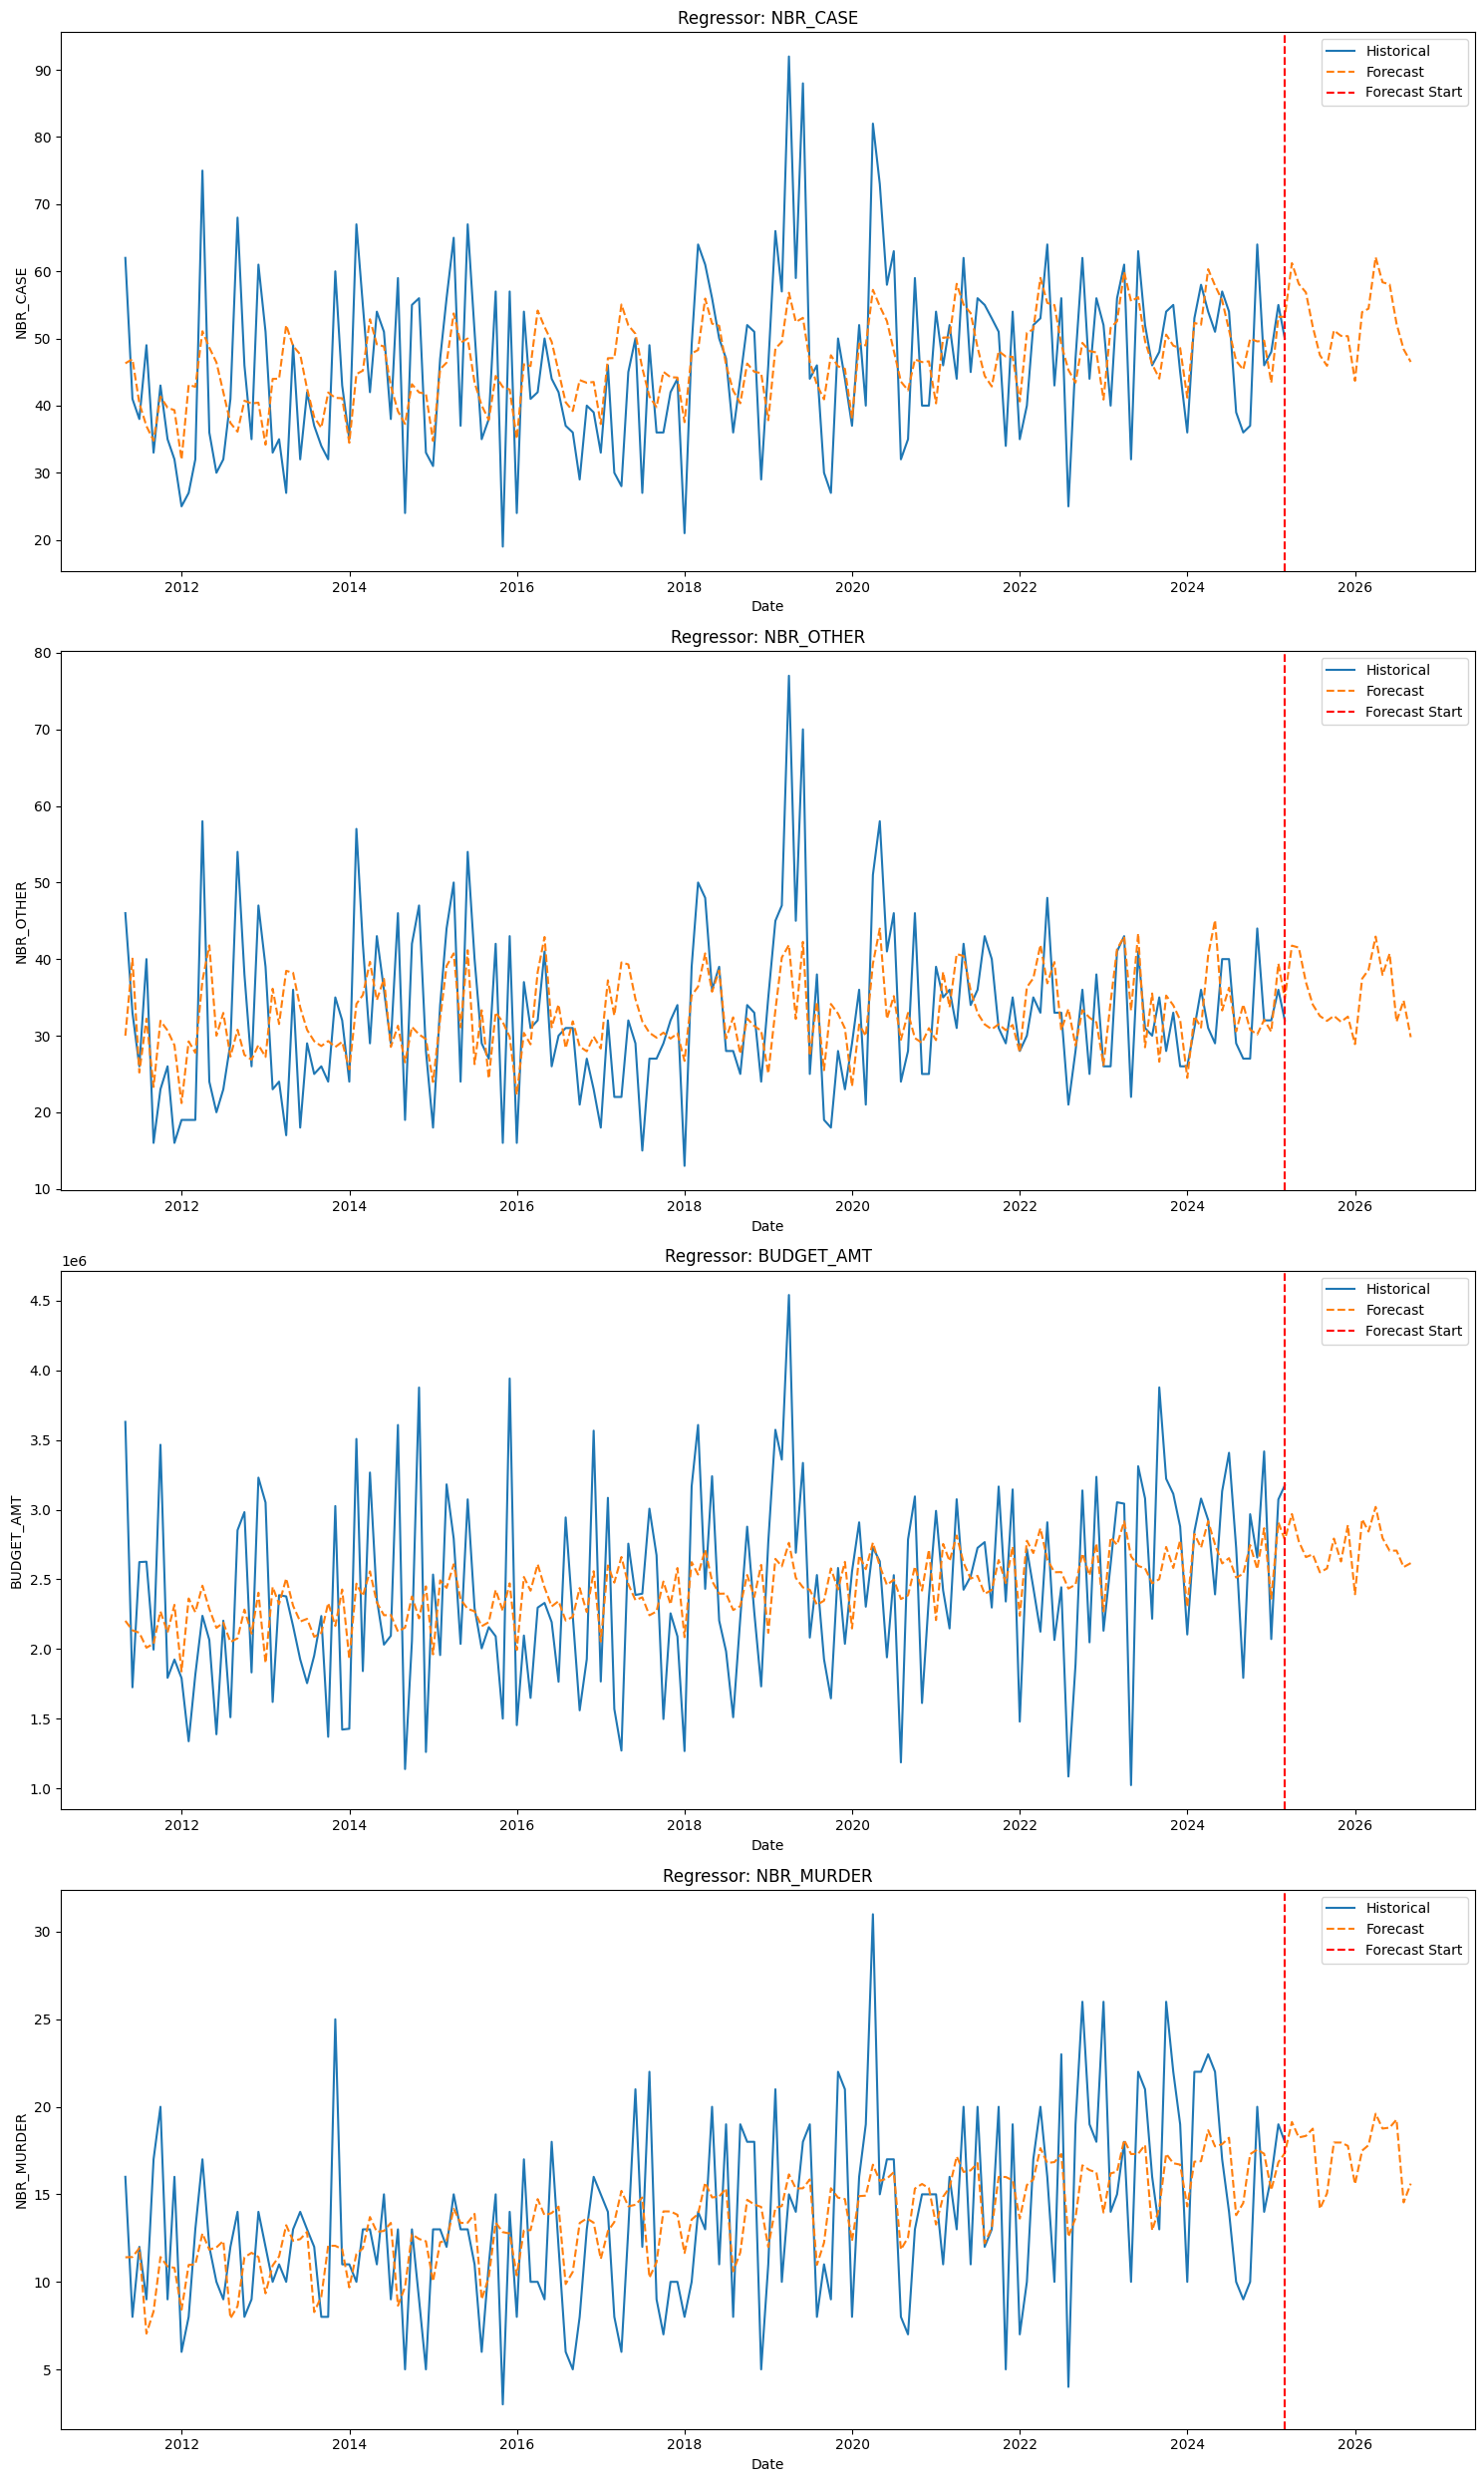

In [50]:
# Plot regressors with Prophet forecasts
def plot_regressor_forecasts(df, ranked_features, forecast_horizon=18):
    plt.figure(figsize=(15, 25))
    num_features = len(ranked_features)
    
    for i, col in enumerate(ranked_features.index):
        # Prepare historical and future data
        df_hist = df[['ACC_MONTH', col]].rename(columns={'ACC_MONTH': 'ds', col: 'y'})
        
        m = Prophet()
        m.fit(df_hist)
        future = m.make_future_dataframe(periods=forecast_horizon, freq='ME')
        forecast = m.predict(future)

        # Plot
        plt.subplot(num_features, 1, i + 1)
        plt.plot(df_hist['ds'], df_hist['y'], label='Historical')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='dashed')
        plt.axvline(x=df_hist['ds'].max(), color='red', linestyle='--', label='Forecast Start')
        plt.title(f'Regressor: {col}')
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
# Run the plotting
plot_regressor_forecasts(df, ranked_features, forecast_horizon=18)    

In [51]:
# Create future dataframe with dates only
m_tmp = Prophet()
m_tmp.fit(df[[date_col, target_col]].rename(columns={date_col: 'ds', target_col: 'y'}))
future_dates = m_tmp.make_future_dataframe(periods=forecast_horizon, freq='ME').tail(forecast_horizon)[['ds']]

# Forecast each top regressor using Prophet
future_regressors = {}

for col in ranked_features.index:
    df_prophet = df[[date_col, col]].rename(columns={date_col: 'ds', col: 'y'})
    m = Prophet()
    m.fit(df_prophet)
    forecast = m.predict(future_dates)
    future_regressors[col] = forecast['yhat'].values



15:46:17 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Build regressor_df for target forecast
regressor_df = future_dates.copy()
for col in ranked_features.index:
    regressor_df[col] = future_regressors[col]



In [53]:
# Train target model with historical data and regressors
full_df = df[[date_col, target_col]].rename(columns={date_col: 'ds', target_col: 'y'})
for col in ranked_features.index:
    full_df[col] = df[col].values

m_target = Prophet()
for col in ranked_features.index:
    m_target.add_regressor(col)

m_target.fit(full_df)



15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
# Forecast target variable
forecast_target = m_target.predict(regressor_df)
forecast_target[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("TOT_PAID_forecast.csv", index=False)




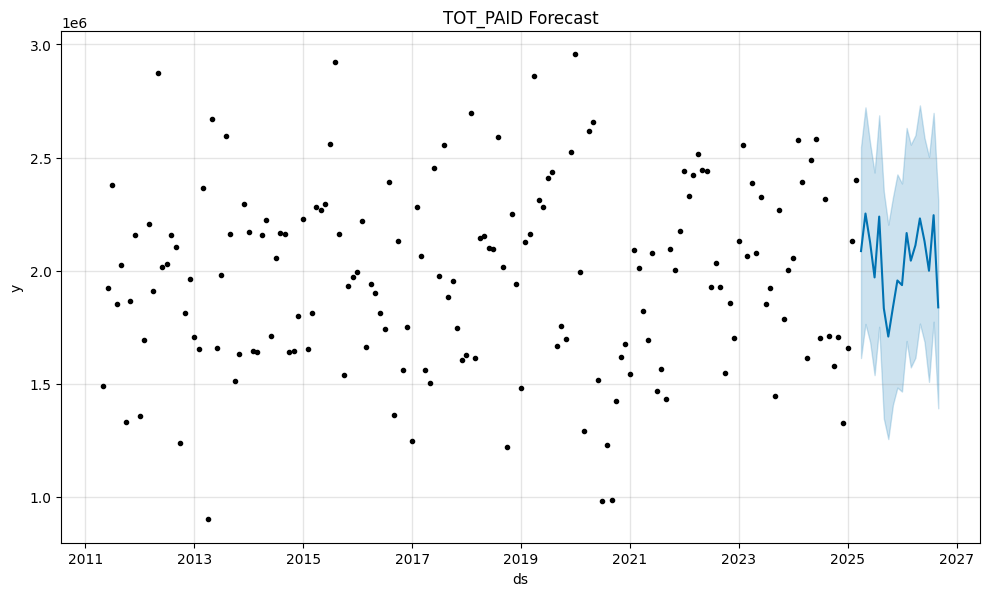

In [55]:
# Plot the forecast
m_target.plot(forecast_target)
plt.title("TOT_PAID Forecast")
plt.show()

15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing



📊 Accuracy for Regressor: NBR_CASE
   RMSE: 8.28
   MAE : 6.90
   MAPE: 15.12%


15:52:48 - cmdstanpy - INFO - Chain [1] start processing



📊 Accuracy for Regressor: NBR_OTHER
   RMSE: 7.32
   MAE : 6.06
   MAPE: 18.67%


15:52:48 - cmdstanpy - INFO - Chain [1] done processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing



📊 Accuracy for Regressor: BUDGET_AMT
   RMSE: 477385.54
   MAE : 407930.35
   MAPE: 15.13%


15:52:48 - cmdstanpy - INFO - Chain [1] done processing



📊 Accuracy for Regressor: NBR_MURDER
   RMSE: 4.36
   MAE : 3.88
   MAPE: 29.32%


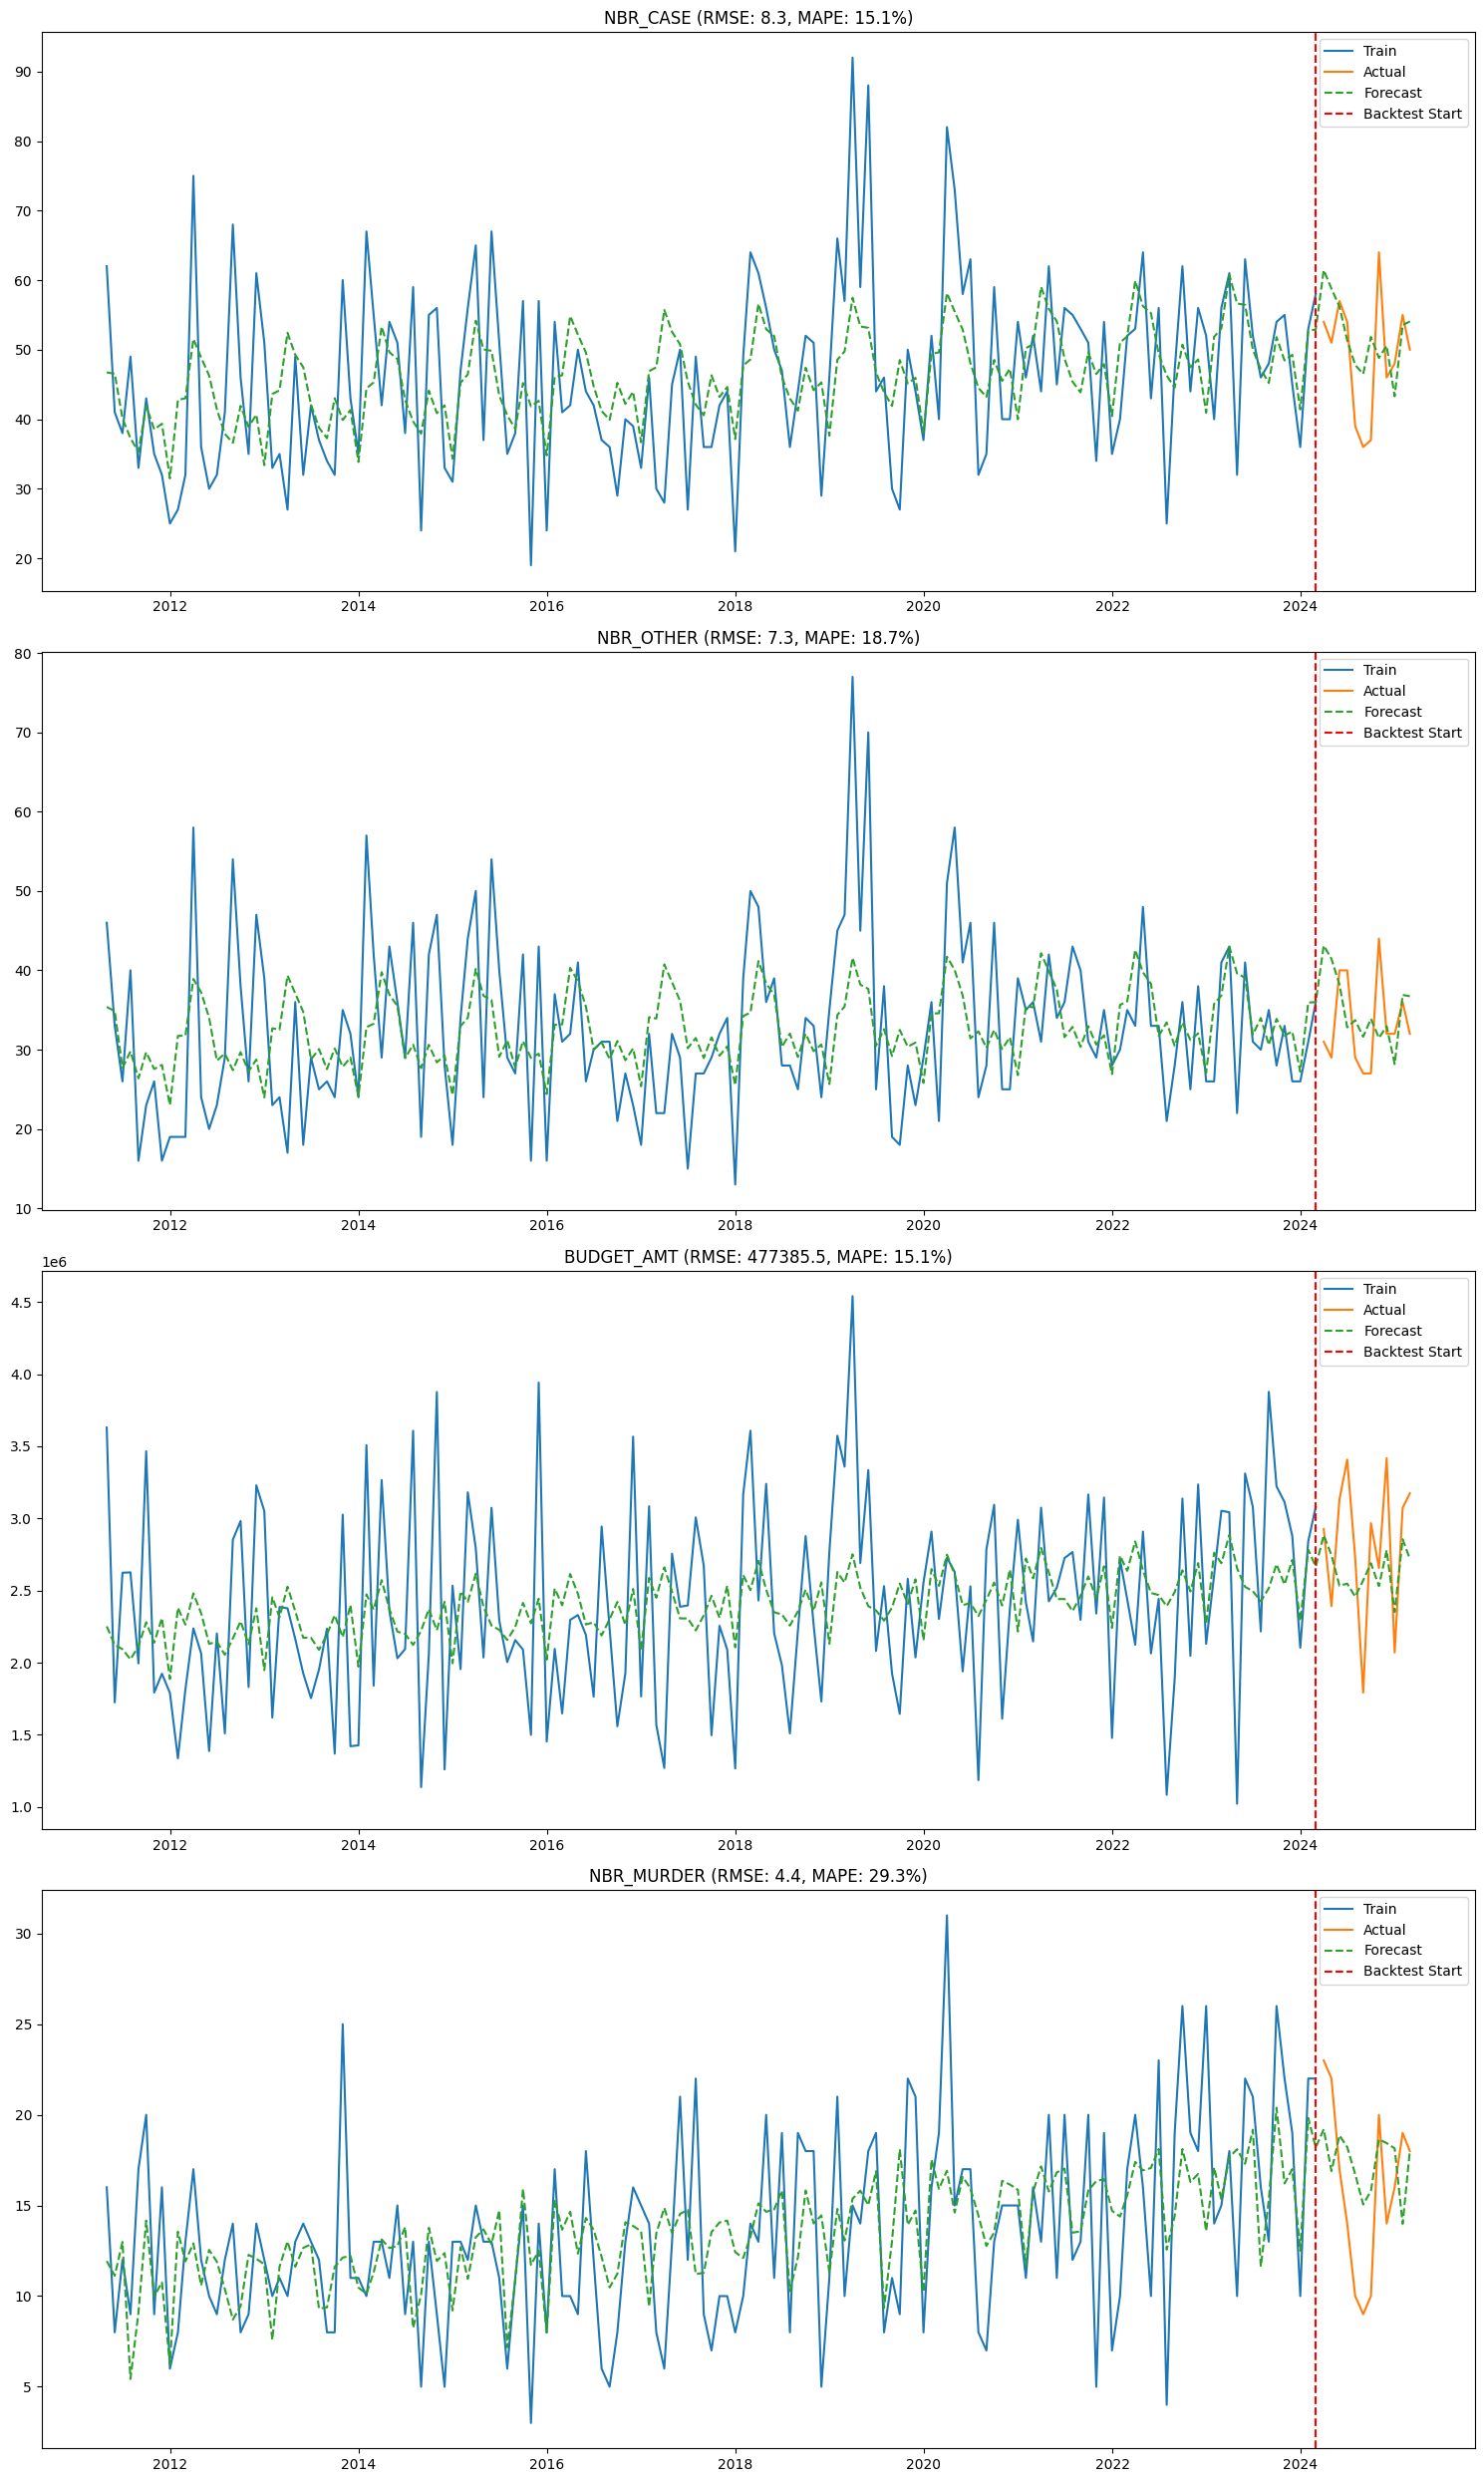

15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:52:49 - cmdstanpy - INFO - Chain [1] done processing



✅ Accuracy for Target (TOT_PAID):
   RMSE: 337556.34
   MAE : 283253.76
   MAPE: 15.86%


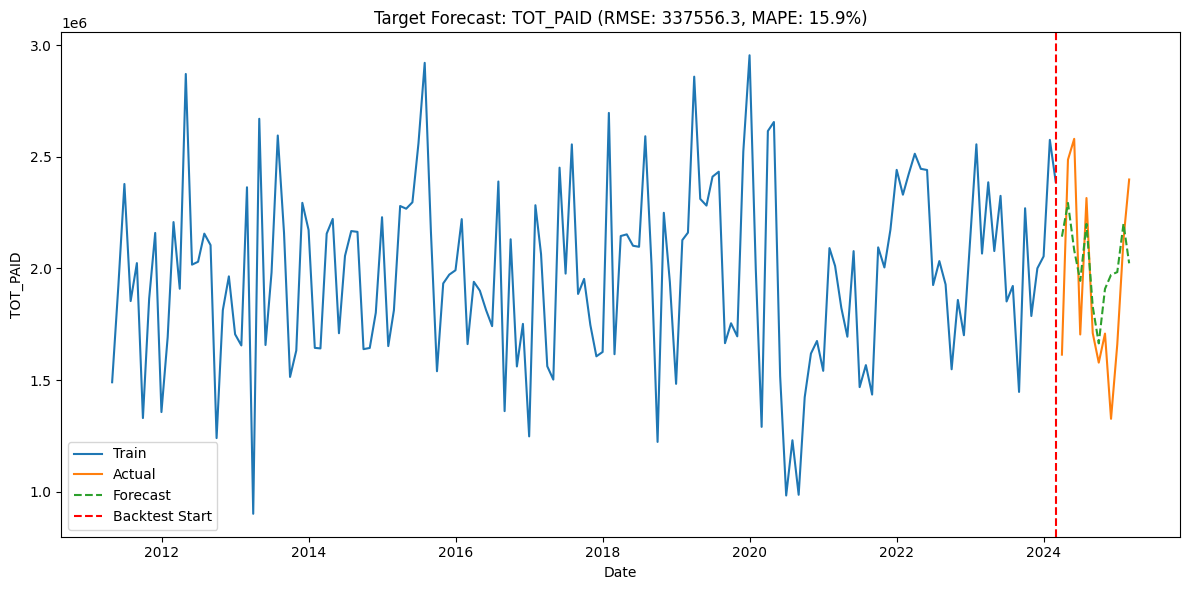

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------------------
# 1. Load & Preprocess Data
# ---------------------------
#df = pd.read_csv("BCM_DATA.csv")
df = pd.read_csv("C:/\GitHub/Machine-Learning/data/BCM_DATA.csv")
df['ACC_MONTH'] = pd.to_datetime(df['ACC_MONTH'])
df = df.sort_values('ACC_MONTH')

# Drop unnecessary columns
df_features = df.drop(columns=['TOT_PAID', 'ACC_MONTH', 'FISCAL_YEAR', 'ACCOUNTING_PERIOD'])
feature_cols = df_features.columns

# Standardize for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# ---------------------------
# 2. Run PCA and Rank Features
# ---------------------------
pca = PCA()
pca.fit(X_scaled)

importance = pd.Series(abs(pca.components_[0]), index=feature_cols)
ranked_features = importance.sort_values(ascending=False)

# ---------------------------
# 3. Accuracy Helper
# ---------------------------
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100

# ---------------------------
# 4. Regressor Forecasts + Accuracy
# ---------------------------
def plot_regressor_forecasts(df, ranked_features, forecast_horizon=18, backtest_period=12):
    plt.figure(figsize=(15, 25))
    
    for i, col in enumerate(ranked_features.index):
        df_hist = df[['ACC_MONTH', col]].rename(columns={'ACC_MONTH': 'ds', col: 'y'})
        train_df = df_hist.iloc[:-backtest_period]
        test_df = df_hist.iloc[-backtest_period:]

        m = Prophet()
        m.fit(train_df)
        future = m.make_future_dataframe(periods=backtest_period, freq='ME')
        forecast = m.predict(future)

        # Accuracy
        forecast_trimmed = forecast[['ds', 'yhat']].set_index('ds').loc[test_df['ds']]
        actuals = test_df.set_index('ds')['y']
        rmse = np.sqrt(mean_squared_error(actuals, forecast_trimmed['yhat']))
        mae = mean_absolute_error(actuals, forecast_trimmed['yhat'])
        mape = mean_absolute_percentage_error(actuals, forecast_trimmed['yhat'])

        print(f"\n📊 Accuracy for Regressor: {col}")
        print(f"   RMSE: {rmse:.2f}")
        print(f"   MAE : {mae:.2f}")
        print(f"   MAPE: {mape:.2f}%")

        # Plot
        plt.subplot(len(ranked_features), 1, i + 1)
        plt.plot(train_df['ds'], train_df['y'], label='Train')
        plt.plot(test_df['ds'], test_df['y'], label='Actual')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='dashed')
        plt.axvline(x=train_df['ds'].max(), color='red', linestyle='--', label='Backtest Start')
        plt.title(f'{col} (RMSE: {rmse:.1f}, MAPE: {mape:.1f}%)')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Run regressor forecast analysis
plot_regressor_forecasts(df, ranked_features, forecast_horizon=18, backtest_period=12)

# ---------------------------
# 5. Forecast TOT_PAID + Accuracy
# ---------------------------
def forecast_target_with_regressors(df, regressors, backtest_period=12, forecast_horizon=18):
    df_target = df[['ACC_MONTH', 'TOT_PAID'] + list(regressors.index)]
    df_target = df_target.rename(columns={'ACC_MONTH': 'ds', 'TOT_PAID': 'y'})

    # Split train/test for backtesting
    train_df = df_target.iloc[:-backtest_period]
    test_df = df_target.iloc[-backtest_period:]

    # Train model
    m = Prophet()
    for reg in regressors.index:
        m.add_regressor(reg)
    m.fit(train_df)

    # Forecast future (test period)
    future = test_df.drop(columns='y')  # keep ds + regressors
    forecast = m.predict(future)

    # Accuracy
    forecast_trimmed = forecast[['ds', 'yhat']].set_index('ds')
    actuals = test_df.set_index('ds')['y']
    rmse = np.sqrt(mean_squared_error(actuals, forecast_trimmed['yhat']))
    mae = mean_absolute_error(actuals, forecast_trimmed['yhat'])
    mape = mean_absolute_percentage_error(actuals, forecast_trimmed['yhat'])

    print(f"\n✅ Accuracy for Target (TOT_PAID):")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE : {mae:.2f}")
    print(f"   MAPE: {mape:.2f}%")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['ds'], train_df['y'], label='Train')
    plt.plot(test_df['ds'], test_df['y'], label='Actual')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='dashed')
    plt.axvline(x=train_df['ds'].max(), color='red', linestyle='--', label='Backtest Start')
    plt.title(f'Target Forecast: TOT_PAID (RMSE: {rmse:.1f}, MAPE: {mape:.1f}%)')
    plt.xlabel("Date")
    plt.ylabel("TOT_PAID")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run target forecasting + accuracy
forecast_target_with_regressors(df, ranked_features, backtest_period=12, forecast_horizon=18)
